## Plot: Learing Curves.

In [1]:
# Importing.
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.loc'] = 'lower right'
plt.rcParams['figure.facecolor'] = '#FFFFFF'

In [2]:
import json

import yaml


def is_env(path: Path, env_id: str) -> bool:
    """Is env?"""
    if os.path.isfile((path / "config.json")):
        with open(path / "config.json", "r") as file_handler:
            config = json.load(file_handler)
    else:
        with open(path / "config.yaml", "r") as file_handler:
            config = yaml.load(file_handler, yaml.FullLoader)
    config_env_id = config["env_id"]
    return config_env_id == env_id

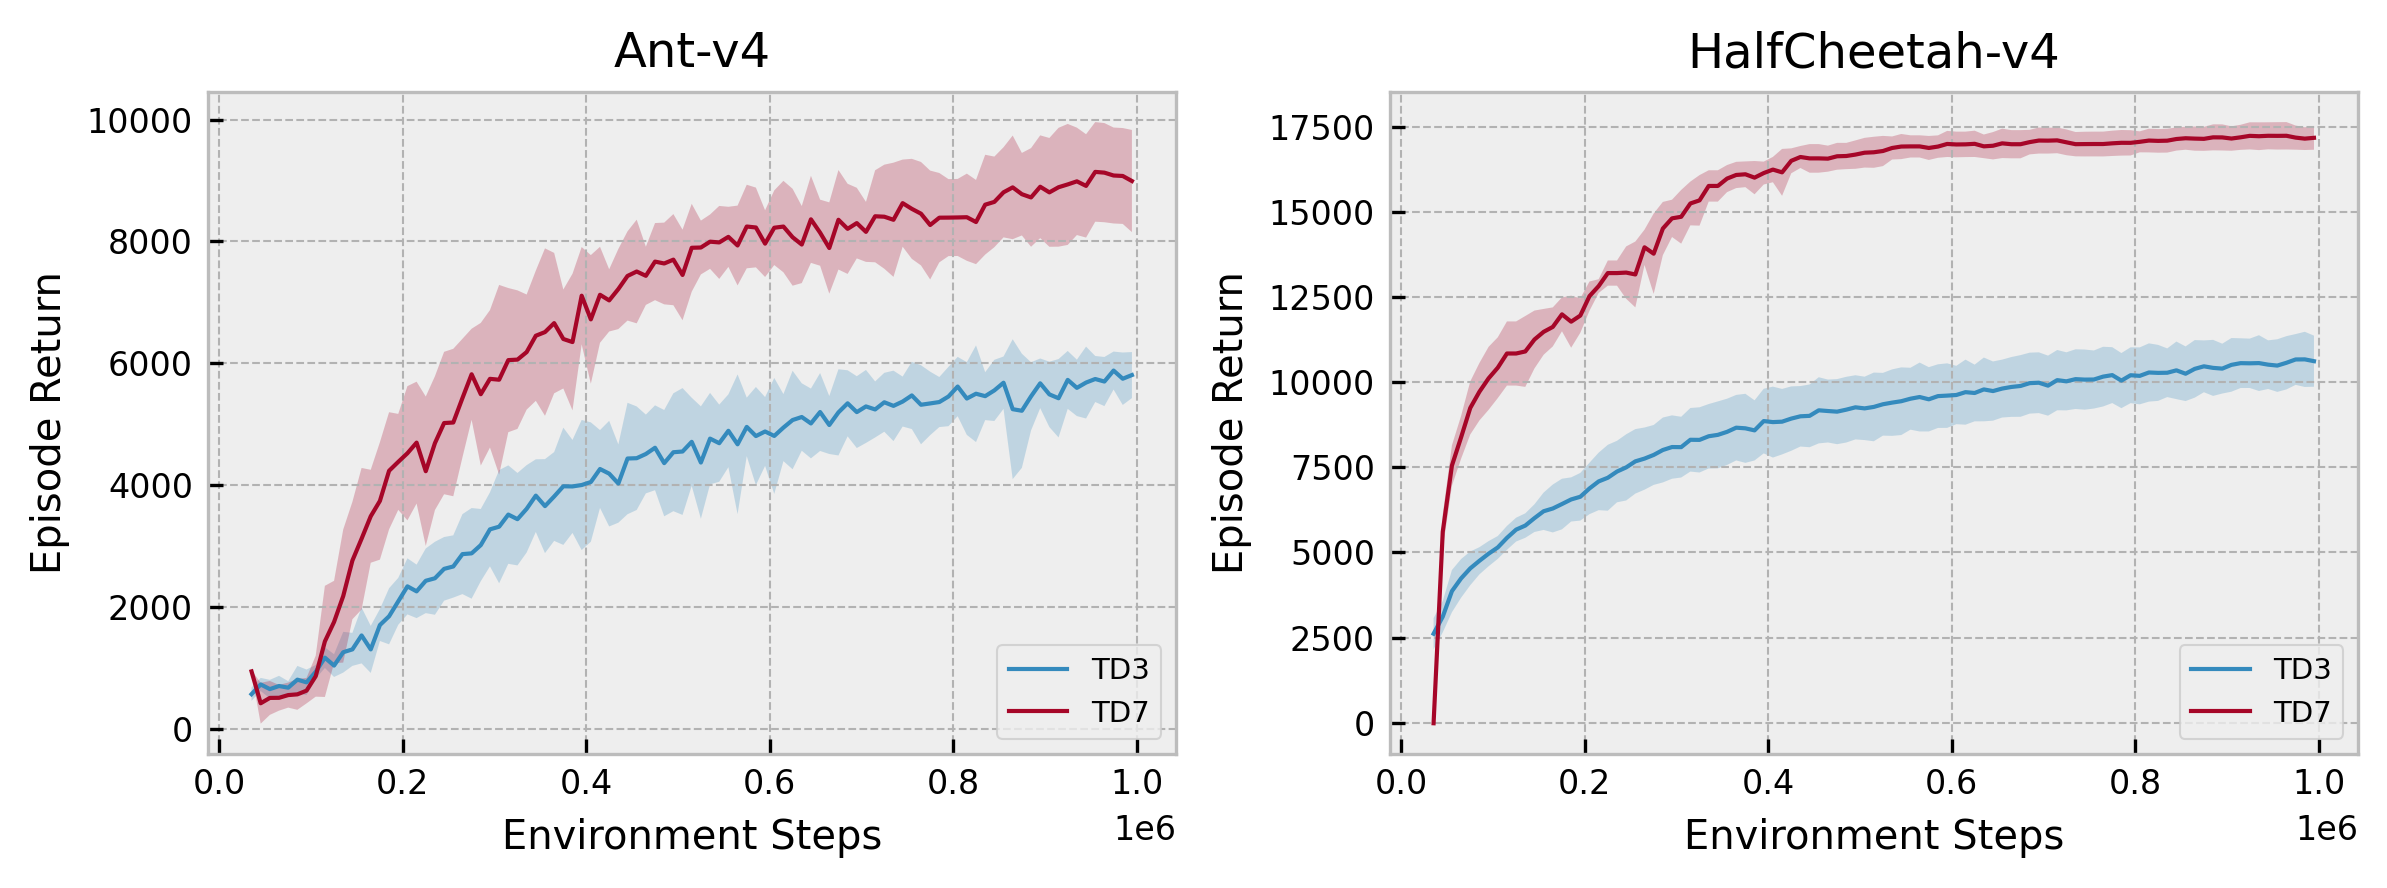

In [47]:
import pandas as pd


env_names = ["Ant-v4", "HalfCheetah-v4"]
algs = ["TD3", "TD7"]
n_envs = len(env_names)
n_row = 1
n_col = n_envs

fig, axs = plt.subplots(n_row, n_col, figsize=(4 * n_col, 3 * n_row))

n_iterations = 1_000_000
initial_iteration = 25_000
interval = 10_000
save_dir = Path("../data/experiment_logging")
alg_paths = [save_dir / alg for alg in algs]
for idx, env_name in enumerate(env_names):
    row, col = idx // n_col, idx % n_col
    for alg_path in alg_paths:
        alg = alg_path.parts[-1]
        all_experiments = [ele for ele in list(alg_path.glob("*")) if is_env(ele, env_name)]
        dfs: list[pd.Series] = [pd.read_csv(ele / "training.log") for ele in all_experiments]
        means, stds = list(), list()
        for jdx in range(1, (n_iterations - initial_iteration) // interval + 1):
            series = np.array([df[df["iteration"] < jdx * interval + initial_iteration].iloc[-1]["perf/mean"] for df in dfs])
            mean = series.mean()
            std = series.std()
            means.append(mean)
            stds.append(std)
        means = np.stack(means)
        stds = np.stack(stds)
        xs = [initial_iteration + ii * interval for ii in range(1, (n_iterations - initial_iteration) // interval + 1)]
        axs[col].plot(xs, means, label=alg, linewidth=1)
        axs[col].fill_between(xs, means - stds, means + stds, alpha=0.25)
        axs[col].set_xlabel('Environment Steps')
        axs[col].set_ylabel('Episode Return')
        axs[col].set_title(f"{env_name}")
        axs[col].legend()
plt.tight_layout()
plt.savefig("../data/learning_curve.png")